## Student Math Performance Predictor - Multi-Model Comparison


Description:
We developed a student performance classification that compares three ML algorithms to predict whether 
a student will be a high or low performer based on their academic.


The code trains, evaluates, and visualizes model performance using standard classification metrics to determine 
the most effective approach for educational outcome prediction.



In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')  


## Load and Prepare Data for Classification


In [ ]:
def load_and_prepare_data(filepath):
    """Load and prepare data for classification"""
    df = pd.read_csv("nas-students-data.csv")
    
    df['Performance_Category'] = (df['Maths_Percentage'] >= df['Maths_Percentage'].median()).astype(int)
    
    df.fillna(df.median(numeric_only=True), inplace=True)
    df.fillna(df.mode().iloc[0], inplace=True)
    
    df_encoded = pd.get_dummies(df, drop_first=True)
    
    X = df_encoded.drop(columns=['Performance_Category'], errors='ignore')
    y = df_encoded['Performance_Category']
    
    return X, y


## Model Evaluation Function

In [31]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model and return classification metrics"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
 
    if model_name == "Linear Regression":
        y_pred = (y_pred >= 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return accuracy, precision, recall, f1


## Data Overview and Train-Test Split


In [32]:
X, y = load_and_prepare_data("nas-students-data.csv")

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Target distribution:")
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape}")


Dataset shape: (8044, 70)
Number of features: 70
Target distribution:
Performance_Category
1    4163
0    3881
Name: count, dtype: int64

Train set size: 6435
Test set size: (1609, 70)


## Data Standardization for Logistic Regression


In [33]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed for Logistic Regression")
print(f"Original feature range: [{X_train.min().min():.2f}, {X_train.max().max():.2f}]")
print(f"Scaled feature range: [{X_train_scaled.min():.2f}, {X_train_scaled.max():.2f}]")


Feature scaling completed for Logistic Regression
Original feature range: [0.00, 259.22]
Scaled feature range: [-6.29, 12.81]


## Train and Evaluate All Models


In [34]:
print("="*50)
print("MODEL COMPARISON RESULTS")
print("="*50)

results = []

models = [
    ("Linear Regression", LinearRegression(), X_train, X_test),
    ("Random Forest", RandomForestClassifier(random_state=42, n_jobs=-1), X_train, X_test),
    ("Logistic Regression", LogisticRegression(random_state=42, max_iter=1000), X_train_scaled, X_test_scaled)
]

for name, model, X_tr, X_te in models:
    print(f"\nTraining {name}...")
    acc, prec, rec, f1 = evaluate_model(model, X_tr, X_te, y_train, y_test, name)
    results.append([name, acc, prec, rec, f1])


MODEL COMPARISON RESULTS

Training Linear Regression...

Linear Regression:
  Accuracy:  0.8701
  Precision: 0.9984
  Recall:    0.7503
  F1-Score:  0.8568

Training Random Forest...

Random Forest:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Training Logistic Regression...

Logistic Regression:
  Accuracy:  0.9938
  Precision: 0.9964
  Recall:    0.9916
  F1-Score:  0.9940


## Results Summary Table


In [35]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score'])

print("\n" + "="*50)
print("SUMMARY TABLE")
print("="*50)
print(results_df.round(4))



SUMMARY TABLE
                 Model  Accuracy  Precision  Recall  F1-Score
0    Linear Regression    0.8701     0.9984  0.7503    0.8568
1        Random Forest    1.0000     1.0000  1.0000    1.0000
2  Logistic Regression    0.9938     0.9964  0.9916    0.9940


## Model Performance Visualization


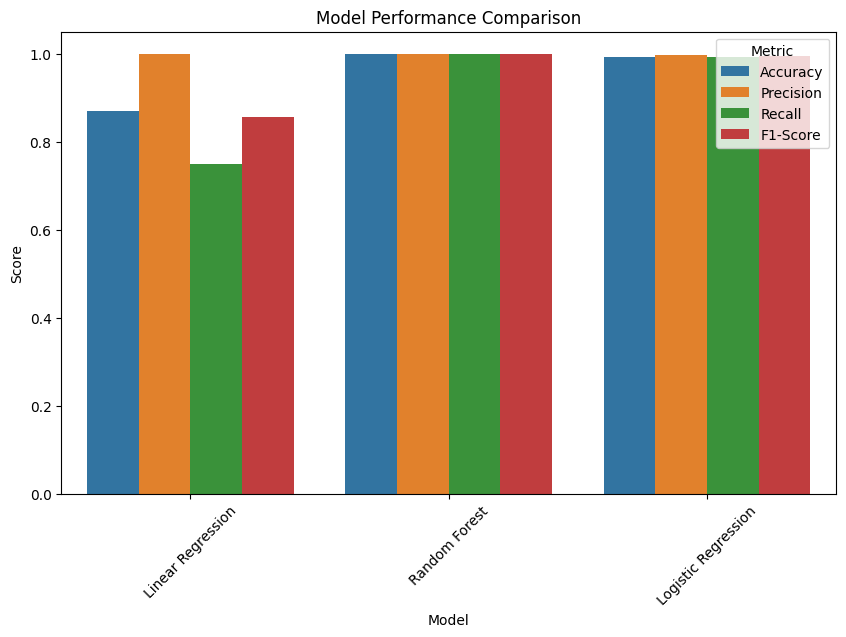

In [36]:
plt.figure(figsize=(10, 6))
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison')
plt.xticks(rotation=45)
plt.show()

## Cross-Validation: Overfitting Check


In [40]:
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='f1')
print(f"Random Forest CV F1 Scores: {rf_cv_scores}")
print(f"Mean CV F1: {rf_cv_scores.mean():.4f} ± {rf_cv_scores.std():.4f}")

if rf_cv_scores.mean() < 0.95:
    print("Possible overfitting detected!")
else:
    print("Model seems robust")


Random Forest CV F1 Scores: [1.         1.         1.         1.         0.99521531]
Mean CV F1: 0.9990 ± 0.0019
Model seems robust


## Additional Validation Split Test


In [41]:
X_temp, X_val, y_temp, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

rf_test = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_test.fit(X_temp, y_temp)

val_score = rf_test.score(X_val, y_val)
print(f"Validation Accuracy: {val_score:.4f}")

if val_score < 0.95:
    print("Model overfitting to training data")


Validation Accuracy: 1.0000
